In [1]:
##Importando os pacotes e módulos necessários
import pandas as pd
import numpy as np
import math

#Para Regressão Linear Simples e Teste F
from scipy import stats
#Para Regressão Linear Múltipla (OLS, GLS e WLS) e Testes Estatísticos
import statsmodels.api as sm
import econtools
import econtools.metrics as mt
#Para Regressão em Painel
from linearmodels import PanelOLS, FirstDifferenceOLS, PooledOLS, RandomEffects

#Pacotes para gráficos (caso precise)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#Pacotes para fazer a coleta dos dados armazenados no mesmo diretório e outros pacotes gerais
import os
import pathlib
import glob
from IPython.display import clear_output

####################################### Criando as Funções ###############################################################

def coletar_dados(nome = ""):
    '''
    Função que le os arquivos do Stata (.dta) - NÃO COLOQUE A EXTENSÃO NA HORA DE NOMEAR O "NOME"!
    O arquivo deve estar na mesma pasta do arquivo de Python ou do notebook do jupyter.
    Deixe em branco para ler o arquivo mais recentemente adicionado à pasta.
    '''

    global df

    #Pegando qual a pasta do arquivo que está sendo usado pra programar
    caminho = pathlib.Path().absolute()

    #No meu caso específico:
    caminho_vinicius = f"{caminho}/datasets"

    #checando se o nome foi inserido ou não; caso não, pegar o arquivo .dta mais recente
    if nome == "":
        try:
            arquivo = max(glob.glob(f"{str(caminho)}/*.dta"), key=os.path.getctime)
            df = pd.read_stata(arquivo)
            print(f"{arquivo}.dta foi lido com sucesso!")
            return df
        except:
            arquivo = max(glob.glob(f"{str(caminho_vinicius)}/*.dta"), key=os.path.getctime)
            df = pd.read_stata(arquivo)
            print(f"{arquivo}.dta foi lido com sucesso!")
            return df
    else:
        try:
            arquivo = f"{str(caminho)}/{str(nome)}.dta"
            df = pd.read_stata(arquivo)
            print(f"{nome}.dta foi lido com sucesso!")
            return df
        except:
            try:
                arquivo = f"{str(caminho_vinicius)}/{str(nome)}.dta"
                df = pd.read_stata(arquivo)
                print(f"{nome}.dta foi lido com sucesso!")
                return df
            except: #caso não tenha sido encontrado o arquivo com o nome inserido
                print('''
                Não foi possível achar o arquivo :(\n
                Verifique se seu nome está correto (sem a extensão) e se ele está no mesmo diretório do programa!
                ''')

def Regressao_Multipla(x, y, constante = "S", robusta = "N"):
    '''
    Função que calcula uma regressão múltipla, sendo, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns.
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares (OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x

    #Criando o Modelo levando em conta a opção de ser uma regressão robusta p/ heteroscedasticidade ou não
    Modelo = sm.OLS(y,X)

    if robusta == "N":
        Resultado = Modelo.fit()
    else:
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    
    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(Resultado.summary())

    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}")
    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade.
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )

def Regressao_MQP(x, y, pesos, constante = "S", robusta = "N"):
    '''
    Função que calcula uma regressão múltipla usando mínimos quadrados ponderados, ou seja,
    recomendada quando o erro é heteroscedástico E se sabe a função da constante. Ela é, por default, computada com um intercepto e com erros padrões não robustos.
    multiplicativa da variância do erro.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    pesos: 1/h, sendo h a constante multiplicativa da variância do erro;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns.
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares(OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    #Criando o Modelo levando em conta a opção de ser uma regressão robusta p/ heteroscedasticidade ou não
    Modelo = sm.WLS(y,X, weights = pesos)
    if robusta == "N":
        Resultado = Modelo.fit()
    else:
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    
    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}\n")
    print(Resultado.summary())

    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )
    
def Regressao_MQGF(x, y, constante = "S", robusta = "N"):
    '''
    Função que calcula uma regressão múltipla usando mínimos quadrados generalizados factíveis, ou seja,
    recomendada quando o erro é heteroscedástico E NÃO se sabe a função da constante multiplicativa da variância do erro, sendo os pesos estimados
    regridindo o log dos quadrados dos resíduos sobre as variáveis explicativas. Os estimadores MQP são gerados com o peso estimado.
    Ela é, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns.
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #Regredindo os valores normalmente a fim de pegar os resíduos
    Regressao_Multipla(x,y, constante, robusta)
    clear_output()

    #Coletando o log dos quadrados dos resíduos
    Log_Res_Quad = np.log(Resíduos**2)

    #Regredindo Log_Res_Quad sobre as variáveis explicativas
    Regressao_Multipla(x,Log_Res_Quad, constante, robusta)
    clear_output()

    #Estimando os pesos
    Pesos = np.exp(Lista_ychapeu)

    #Fazendo uma Regressão MQP
    Regressao_MQP(x,y, 1/Pesos, constante, robusta)

def Teste_LM(x, y, Restrições, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste LM e dá o resultado teste de hipótese para o caso de todas as restrições serem conjuntamente estatisticamente não-significantes.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Restrições: lista ou array com os valores a serem tirados do modelo restrito;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''

    ##Definindo as variáveis de cada modelo
    ModeloIrrestrito = list(x)
    ModeloRestrito = []
    Restrições = list(Restrições)

    Numero_de_Observações = len(y)
    GL_ir = Numero_de_Observações - (len(ModeloIrrestrito) + 1)
    GL_r = len(Restrições)

    for i in ModeloIrrestrito:
        if i not in Restrições:
            ModeloRestrito.append(i)
    
    #Fazendo a regressão do modelo restrito e armazenando os resíduos
    Regressao_Multipla(df[ModeloRestrito], y)
    Resíduos_r = Resíduos

    #Fazendo a regressão dos resíduos sobre as variáveis independentes e armazenando o R2
    Regressao_Multipla(x, Resíduos_r)
    Ru = Resultado.rsquared

    #Calculando a estatística LM
    LM = Numero_de_Observações*Ru

    #Calculando o p-valor
    ##Calculando o P-valor de F
    P_valor = stats.chi2.sf(LM,GL_r)

    #Limpando a tela
    clear_output()

    #Printando o resultado
    if Nivel_de_Significância > P_valor:
        print(f"O valor de LM é {round(LM,3)} e seu p-valor é {round(P_valor,7)}. Portanto, rejeita-se Ho a um nível de significância de {Nivel_de_Significância*100}%.")
    else:
        print(f"O valor de LM é {round(LM,3)} e seu p-valor é {round(P_valor,7)}. Portanto, não se rejeita Ho a um nível de significância de {Nivel_de_Significância*100}%.")


def Teste_F(x, y, Restrições, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste F e dá o resultado teste de hipótese para o caso de todas as restrições serem conjuntamente estatisticamente não-significantes.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Restrições: lista ou array com os valores a serem tirados do modelo restrito;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''

    ##Definindo as variáveis de cada modelo
    #para testar igualdade dos coeficientes, F2, p_valueF2 = results.Ftest(['ACT', 'skipped'], equal=True)
    ModeloIrrestrito = list(x)
    ModeloRestrito = []
    Restrições = list(Restrições)

    Numero_de_Observações = len(y)
    GL_ir = Numero_de_Observações - (len(ModeloIrrestrito) + 1)
    GL_r = len(Restrições)

    for i in ModeloIrrestrito:
        if i not in Restrições:
            ModeloRestrito.append(i)

    ##Fazendo as regressões de cada modelo
    Regressao_Multipla(x, y)
    SQR_ir = SQR
    VarianciaReg_ir = EPR**2

    Regressao_Multipla(df[ModeloRestrito], y)
    SQR_r = SQR

    #Limpando a tela
    clear_output()
    
    ##Calculando F
    F = (SQR_r - SQR_ir)/(len(Restrições)*VarianciaReg_ir)

    ##Calculando o P-valor de F
    P_valor = stats.f.sf(F,GL_r,GL_ir)

    if Nivel_de_Significância > P_valor:
        print(f"O valor de F é {round(F,3)} e seu p-valor é {round(P_valor,7)}. Portanto, rejeita-se Ho à significância de {Nivel_de_Significância*100}%.")
    else:
        print(f"O valor de F é {round(F,3)} e seu p-valor é {round(P_valor,7)}. Portanto, não se rejeita Ho à significância de {Nivel_de_Significância*100}%.")

def Teste_t_Dois_Coeficientes_Iguais(x, y, Coeficientes_Testados_para_serem_iguais, Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste t para verificar se dois coeficientes são iguais.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Coeficientes_Testados_para_serem_iguais: array com os valores dos coeficientes que querem ser testados;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    
    ##Fazendo a regressão do modelo irrestrito
    Regressao_Multipla(x, y)
    clear_output()

    #Fazendo o objeto de lista que será usado no teste
    Teste =[0]
    Num_de_Variaveis = 1

    for i in list(x):
        if i not in list(Coeficientes_Testados_para_serem_iguais):
            Teste.append(0)
        elif (Num_de_Variaveis % 2 == 0):
            Teste.append(-1)
        else:
            Teste.append(1)
            Num_de_Variaveis += 1

    Teste_t = Resultado.t_test(Teste)
    print(f"A estatística do teste é {Teste_t.tvalue}, o que resulta em um p-valor de {Teste_t.pvalue,6}")

def Teste_Heteroscedasticidade_BP(x, y, constante = "S", Nivel_de_Significância = 0.05, Estatística = "LM"):
    '''
    Função que executa o teste de Breusch-Pagan para a heteroscedasticidade.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    Estatística = LM ou F
    '''

    #Fazendo a regressão e limpando a tela
    Regressao_Multipla(x,y,constante)
    clear_output()

    #Calculando o quadrado dos resíduos
    Res_Quad = Resíduos**2

    #Realizando o teste F ou LM de Res_Quad sobre as variaveis dependentes para ver se há correlação
    if Estatística == "LM":
        Teste_LM(x, Res_Quad, x, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")
    else:
        Teste_F(x, Res_Quad, x, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")

def Teste_Heteroscedasticidade_White(x, y, constante = "S", Nivel_de_Significância = 0.05, Estatística = "LM"):
    '''
    Função que executa o teste de White (modificado por Wooldridge) para a heteroscedasticidade.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    Estatística: LM ou F
    '''

    #Fazendo a regressão e limpando a tela
    Regressao_Multipla(x,y,constante)
    clear_output()

    #Calculando o quadrado dos resíduos
    Res_Quad = Resultado.resid**2

    #Calculando o quadrado dos valores previstos
    Previstos = Lista_ychapeu
    Previstos2 = Previstos**2

    #Criando um dataframe pra armazenar esses valores
    dfy_y2 = pd.DataFrame({"y":Previstos,"y2":Previstos2})
    y_y2 = dfy_y2[['y','y2']]

    #Realizando o teste F ou LM de Res_Quad sobre y e y^2
    if Estatística == "LM":
        Teste_LM(y_y2, Res_Quad, y_y2, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")
    else:
        Teste_F(y_y2, Res_Quad, y_y2, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")

def RESET(x, y, constante = "S", robusta = "N", Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste RESET para verificar a adequação das formas funcionais.
    Ho: o modelo está bem especificado.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    #Fazendo uma regressão múltipla e limpando a tela
    Regressao_Multipla(x, y, constante)
    clear_output()

    #Verificando o tipo da covariância selecionada
    if robusta == "N":
        tipo = 'nonrobust'
    else:
        tipo = 'HC1'

    Teste = sm.stats.diagnostic.linear_reset(Resultado, power = 2, use_f = False, cov_type = tipo)
    
    if Teste.pvalue < Nivel_de_Significância:
        print(f"""
        O p-valor do teste foi de {np.around(Teste.pvalue,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, rejeita-se Ho (o modelo está MAL especificado)."""
        )
    else:
        print(f"""
        O p-valor do teste foi de {np.around(Teste.pvalue,6)}, maior que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, não se rejeita Ho (o modelo NÃO está MAL especificado)"""
        )

def Teste_J_Davidson_MacKinnon(x1,x2, y, constante = "S", robusta = "N", Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste J para verificar qual o modelo mais adequado (dentre os dois colocados).
    Ho: o modelo 1 é preferível (ver o p-valor do último coeficiente).

    x1: lista ou array com os valores das variáveis independentes do primeiro modelo;
    x2: lista ou array com os valores das variáveis independentes do segundo modelo;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    
    #Fazendo a regressão do segundo modelo
    Regressao_Multipla(x2, y, constante, robusta)
    clear_output()

    #Criando um novo dataframe e adicionando os valores previstos do modelo 2 à x
    Valores_Previstos_2 = pd.DataFrame({'Previsão M1':Lista_ychapeu})
    x = pd.concat([x1, Valores_Previstos_2], axis=1, sort=False)

    #Fazendo a regressão do primeiro modelo sobre x
    Regressao_Multipla(x, y, constante, robusta)
    clear_output()

    #Pegando o p-valor do teste
    P_valor = Resultado.pvalues[-1]

    if P_valor < Nivel_de_Significância:
        print(f"""
        O p-valor do teste foi de {np.around(P_valor,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, rejeita-se Ho (ou seja, o modelo 2 ({list(x2)}) é mais bem especificado)."""
        )
    else:
        print(f"""
        O p-valor do teste foi de {np.around(P_valor,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, não se rejeita Ho (ou seja, o modelo 1 ({list(x1)}) é mais bem especificado)."""
        )

######### Funções de Dados em Painel #########
def Arrumar_Painel():
    '''
    Função que transforma o painel num formato que o PanelOLS consegue ler (index multinível e coluna do tipo categoria para os anos)
    '''
    global df

    # pedir a coluna com os indivíduos; se o nome for inválido, sair da função.
    coluna_individuos = str(input('Qual o rótulo da coluna de indivíduos/observações?\n'))
    if coluna_individuos not in df.columns:
        print("Coluna de indivíduos não está no dataframe. Insira uma coluna válida e tente novamente!")
        return None
    
    # pedir a coluna com os períodos de tempo; se o valor for inválido, sair da função.
    coluna_tempo = str(input('Qual o rótulo da coluna de tempo?\n'))
    if coluna_tempo not in df.columns:
        print("Coluna de tempo não está no dataframe. Insira uma coluna válida e tente novamente!")
        return None

    ## arrumando o painel
    periodos = pd.Categorical(df[coluna_tempo])
    df = df.set_index([coluna_individuos,coluna_tempo])
    df[coluna_tempo] = periodos
    return df

def Reg_Painel_Primeiras_Diferenças (x,y, robusta = "N"):
    '''
    Função que calcula uma regressão de primeiras diferenças SEM um intercepto, sendo, por default, computada com erros padrões não robustos.
    Para calcular a regressão com um intercepto, ver o notebook "Cap 13 e 14".
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns.
    '''
    Modelo = FirstDifferenceOLS(y, x)
    Resultado = Modelo.fit()
    print(Resultado)

def Reg_Painel_Efeitos_Fixos(x, y, constante = "S", robusta = "N"):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões não robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns.
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção de ser uma regressão robusta p/ heteroscedasticidade ou não
    Modelo = PanelOLS(y,X, entity_effects=True)
    if robusta == "N":
        Resultado = Modelo.fit()
    else:
        Resultado = Modelo.fit(cov_type = 'robust')
    print(Resultado)

def Reg_Painel_MQO_Agrupado(x, y, constante = "S", robusta = "S"):
    '''
    Função que calcula uma regressão por MQO agrupado, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão robustos.
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção de ser uma regressão robusta p/ heteroscedasticidade ou não
    Modelo = PooledOLS(y,X)
    if robusta == "N":
        Resultado = Modelo.fit()
    else:
        Resultado = Modelo.fit(cov_type = 'robust')
    print(Resultado)

def Reg_Painel_Efeitos_Aleatórios(x, y, constante = "S"):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão robustos.
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo
    Modelo = RandomEffects(y,X)
    Resultado = Modelo.fit()
    print(Resultado)

### Exercício C2

In [2]:
coletar_dados('WAGE2')
df['educ_IQ'] = df['educ']*df['IQ']
display(df)

WAGE2.dta foi lido com sucesso!


,wage,hours,IQ,KWW,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc,lwage,educ_IQ
0,769,40,93,35,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0,6.645091,1116
1,808,50,119,41,18,11,16,37,1,0,0,1,1,NaN,14.0,14.0,6.694562,2142
2,825,40,108,46,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0,6.715384,1512
3,650,40,96,32,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0,6.476973,1152
4,562,40,74,27,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0,6.331502,814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930,520,40,79,28,16,6,1,30,1,1,1,0,0,1.0,11.0,NaN,6.253829,1264
931,1202,40,102,32,13,10,3,31,1,0,1,1,7,7.0,8.0,6.0,7.091742,1326
932,538,45,77,22,12,12,10,28,1,1,1,0,9,NaN,7.0,NaN,6.287858,924
933,873,44,109,25,12,12,12,28,1,0,1,0,1,1.0,NaN,11.0,6.771935,1308


O exemplo 9.3 usa como variáveis exógenas a lista 'educ','exper','tenure','married','south','urban','black','IQ','educ_IQ' e 'lwage' como variável endógena.

In [3]:
## Fazendo a Regressão Original
x = df[['educ','exper','tenure','married','south','urban','black','IQ']]
y = df['lwage']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     41.27
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           1.52e-56
Time:                        16:06:52   Log-Likelihood:                -375.09
No. Observations:                 935   AIC:                             768.2
Df Residuals:                     926   BIC:                             811.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1764      0.128     40.441      0.0

In [4]:
## Substituindo IQ por KWW nas variáveis exógenas
x = df[['educ','exper','tenure','married','south','urban','black','KWW']]
y = df['lwage']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.259
Model:                            OLS   Adj. R-squared:                  0.252
Method:                 Least Squares   F-statistic:                     40.39
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           1.93e-55
Time:                        16:06:52   Log-Likelihood:                -377.71
No. Observations:                 935   AIC:                             773.4
Df Residuals:                     926   BIC:                             817.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.3588      0.114     47.172      0.0

In [5]:
##Usando IQ E KWW como proxis para aptidão
x = df[['educ','exper','tenure','married','south','urban','black','IQ','KWW']]
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     37.28
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           1.25e-56
Time:                        16:06:52   Log-Likelihood:                -372.94
No. Observations:                 935   AIC:                             765.9
Df Residuals:                     925   BIC:                             814.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1756      0.128     40.506      0.0

In [6]:
## Testando a significância conjunta de IQ e KWW
x = df[['educ','exper','tenure','married','south','urban','black','IQ','KWW']]
y = df['lwage']
Teste_F(x,y, df[['IQ','KWW']])

O valor de F é 8.595 e seu p-valor é 0.0002002. Portanto, rejeita-se Ho à significância de 5.0%.


## Exercício C3

In [7]:
# Checando quais as colunas do Dataframe
# Hipótese: tamanho da empresa - aproximado por sales - influencia na obtenção de subsídios?
for i in df.columns:
    print(i)

wage
hours
IQ
KWW
educ
exper
tenure
age
married
black
south
urban
sibs
brthord
meduc
feduc
lwage
educ_IQ


In [8]:
## Fazendo a regressão simples de lscrap sobre grant no ano de 1988
# Baixando a base de dados e pegando apenas o ano de 1988
coletar_dados('JTRAIN')
df_88 = df.loc[df['d88'] == 1]

# Dropando os valores nulos
df_88.dropna(subset=['lscrap','grant'], axis = 0, inplace = True)

# Fazendo a regressão
x = df_88[['grant']]
y = df_88['lscrap']
Regressao_Multipla(x,y)

JTRAIN.dta foi lido com sucesso!
                            OLS Regression Results                            
Dep. Variable:                 lscrap   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.019
Method:                 Least Squares   F-statistic:                   0.01948
Date:                Thu, 18 Feb 2021   Prob (F-statistic):              0.890
Time:                        16:06:53   Log-Likelihood:                -94.660
No. Observations:                  54   AIC:                             193.3
Df Residuals:                      52   BIC:                             197.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.40

In [9]:
## Usando a variável lscrap de 87 como regressora
df_88.rename(columns={'lscrap_1':'lscrap_87'}, inplace=True)

# Fazendo a regressão
x = df_88[['grant','lscrap_87']]
y = df_88['lscrap']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                 lscrap   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     174.9
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           1.47e-23
Time:                        16:06:53   Log-Likelihood:                -39.000
No. Observations:                  54   AIC:                             84.00
Df Residuals:                      51   BIC:                             89.97
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0212      0.089      0.238      0.8

In [10]:
# Fazendo a regressão com erros robustos com relação a heteroscedasticidade
x = df_88[['grant','lscrap_87']]
y = df_88['lscrap']
Regressao_Multipla(x,y, robusta='S')

                            OLS Regression Results                            
Dep. Variable:                 lscrap   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     77.79
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           3.22e-16
Time:                        16:06:53   Log-Likelihood:                -39.000
No. Observations:                  54   AIC:                             84.00
Df Residuals:                      51   BIC:                             89.97
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0212      0.100      0.213      0.8

## Exercício C4

In [11]:
coletar_dados('INFMRT')

INFMRT.dta foi lido com sucesso!


,year,infmort,afdcprt,popul,pcinc,physic,afdcper,d90,lpcinc,lphysic,DC,lpopul
0,1987,8.3,52,1186,13996,173,4.384486,0,9.546527,5.153292,0,7.078341
1,1990,6.2,62,1228,17125,178,5.048860,1,9.748295,5.181784,0,7.113142
2,1987,7.8,11,1056,18083,186,1.041667,0,9.802728,5.225747,0,6.962244
3,1990,7.1,21,1109,21051,200,1.893598,1,9.954703,5.298317,0,7.011214
4,1987,8.5,20,547,14267,244,3.656307,0,9.565704,5.497168,0,6.304449
...,...,...,...,...,...,...,...,...,...,...,...,...
97,1990,7.9,2023,29760,20547,244,6.797715,1,9.930470,5.497168,0,10.300920
98,1987,10.4,19,524,18461,138,3.625954,0,9.823416,4.927254,0,6.261492
99,1990,10.5,24,550,20867,146,4.363636,1,9.945924,4.983607,0,6.309918
100,1987,8.9,41,1082,15569,225,3.789279,0,9.653037,5.416101,0,6.986567


In [12]:
## Pegando apenas os dados de 1990
df_90 = df.loc[df['year'] == 1990]

# Fazendo a regressão com a dummy do estado de Columbia
x = df_90[['lpcinc','lphysic','lpopul','DC']]
y = df_90['infmort']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                infmort   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     25.71
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           3.15e-11
Time:                        16:06:53   Log-Likelihood:                -80.968
No. Observations:                  51   AIC:                             171.9
Df Residuals:                      46   BIC:                             181.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9548     12.419      1.929      0.0

In [13]:
# Pegando apenas os dados fora de DC
df_nDC = df_90.loc[df_90['DC'] == 0]

# Fazendo a regressão com a dummy do estado de Columbia
x = df_nDC[['lpcinc','lphysic','lpopul']]
y = df_nDC['infmort']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                infmort   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     5.763
Date:                Thu, 18 Feb 2021   Prob (F-statistic):            0.00197
Time:                        16:06:54   Log-Likelihood:                -79.876
No. Observations:                  50   AIC:                             167.8
Df Residuals:                      46   BIC:                             175.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         23.9548     12.419      1.929      0.0

## Exercício C8

In [14]:
coletar_dados('TWOYEAR')

TWOYEAR.dta foi lido com sucesso!


,female,phsrank,BA,AA,black,hispanic,id,exper,jc,univ,...,medcity,submed,lgcity,sublg,vlgcity,subvlg,ne,nc,south,totcoll
0,1,65,0,0,0,0,19.0,161,0.000000,0.000000,...,0,0,0,1,0,0,1,0,0,0.000000
1,1,97,0,0,0,0,93.0,119,0.000000,7.033333,...,0,0,0,0,0,0,0,1,0,7.033333
2,1,44,0,0,0,0,96.0,81,0.000000,0.000000,...,0,0,0,1,0,0,1,0,0,0.000000
3,1,34,0,0,0,1,119.0,39,0.266667,0.000000,...,0,0,0,0,0,0,0,0,0,0.266667
4,1,80,0,0,0,0,132.0,141,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6758,1,50,0,0,0,0,89903.0,62,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0.000000
6759,1,50,0,0,0,0,89908.0,111,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0.000000
6760,0,50,0,0,0,0,89933.0,146,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0.000000
6761,0,50,0,0,0,0,89955.0,125,0.000000,0.000000,...,0,0,0,0,0,0,0,0,1,0.000000


In [15]:
## Coletando as estatísticas descritivas de 'stotal'
df['stotal'].describe()

count    6763.000000
mean        0.047483
std         0.853544
min        -3.324797
25%        -0.327343
50%         0.000000
75%         0.610791
max         2.235366
Name: stotal, dtype: float64

In [16]:
## Fazendo as regressões simples
y1 = df['jc']
x = df[['stotal']]
Regressao_Multipla(x,y1)

                            OLS Regression Results                            
Dep. Variable:                     jc   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.032
Date:                Thu, 18 Feb 2021   Prob (F-statistic):              0.310
Time:                        16:06:54   Log-Likelihood:                -7846.3
No. Observations:                6763   AIC:                         1.570e+04
Df Residuals:                    6761   BIC:                         1.571e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3384      0.009     35.983      0.0

In [17]:
## Fazendo as regressões simples
y2 = df['univ']
x = df[['stotal']]
Regressao_Multipla(x,y2)

                            OLS Regression Results                            
Dep. Variable:                   univ   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     1575.
Date:                Thu, 18 Feb 2021   Prob (F-statistic):          8.95e-310
Time:                        16:06:54   Log-Likelihood:                -14512.
No. Observations:                6763   AIC:                         2.903e+04
Df Residuals:                    6761   BIC:                         2.904e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8707      0.025     74.248      0.0

In [18]:
df.columns

Index(['female', 'phsrank', 'BA', 'AA', 'black', 'hispanic', 'id', 'exper',
       'jc', 'univ', 'lwage', 'stotal', 'smcity', 'medcity', 'submed',
       'lgcity', 'sublg', 'vlgcity', 'subvlg', 'ne', 'nc', 'south', 'totcoll'],
      dtype='object')

In [19]:
## Fazendo a regressão de 4.17 adicionando 'stotal'
x = df[['jc','univ','exper','stotal']]
y = df['lwage']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     500.2
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:06:55   Log-Likelihood:                -3862.5
No. Observations:                6763   AIC:                             7735.
Df Residuals:                    6758   BIC:                             7769.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4953      0.021     70.473      0.0

In [20]:
## Fazendo o teste t para ver se  os coeficientes de jc e univ são iguais:
Teste_t_Dois_Coeficientes_Iguais(x,y, df[['jc','univ']])

A estatística do teste é [[-0.80552407]], o que resulta em um p-valor de (array(0.42054566), 6)


In [21]:
## Criando a coluna de stotal2
df['stotal2'] = df['stotal']**2

## Fazendo a regressão
x = df[['jc','univ','exper','stotal','stotal2']]
y = df['lwage']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     400.2
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:06:55   Log-Likelihood:                -3862.4
No. Observations:                6763   AIC:                             7737.
Df Residuals:                    6757   BIC:                             7778.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4940      0.021     69.635      0.0

In [22]:
## Criando a coluna de stotal_jc e stotal_univ
df['stotal_jc'] = df['stotal']*df['jc']
df['stotal_univ'] = df['stotal']*df['univ']

## Fazendo o teste F
x = df[['jc','univ','exper','stotal','stotal_jc','stotal_univ']]
y = df['lwage']
Teste_F(x,y,df[['stotal_jc','stotal_univ']])

O valor de F é 1.959 e seu p-valor é 0.1410201. Portanto, não se rejeita Ho à significância de 5.0%.


## Exercício C10

In [23]:
coletar_dados('JTRAIN2')
train2 = df

JTRAIN2.dta foi lido com sucesso!


In [24]:
#Pegando qual a pasta do arquivo que está sendo usado pra programar
caminho = pathlib.Path().absolute()
caminho_vinicius = f"{caminho}/datasets"
arquivo = f"{str(caminho_vinicius)}/JTRAIN3.dta"
train3 = pd.read_stata(arquivo)
print(f"jtrain3.dta foi lido com sucesso!")

jtrain3.dta foi lido com sucesso!


In [25]:
train2['avgre'] = (train2['re74'] + train2['re75'])/2
display(train2)
##train2 é resultado de um experimento de treinamento profissional

,train,age,educ,black,hisp,married,nodegree,mosinex,re74,re75,re78,unem74,unem75,unem78,lre74,lre75,lre78,agesq,mostrn,avgre
0,1,37,11,1,0,1,1,13,0.000000,0.000000,9.930050,1,1,0,0.000000,0.000000,2.295566,1369,13,0.000000
1,1,22,9,0,1,0,1,13,0.000000,0.000000,3.595890,1,1,0,0.000000,0.000000,1.279792,484,13,0.000000
2,1,30,12,1,0,0,0,13,0.000000,0.000000,24.909500,1,1,0,0.000000,0.000000,3.215249,900,13,0.000000
3,1,27,11,1,0,0,1,13,0.000000,0.000000,7.506150,1,1,0,0.000000,0.000000,2.015723,729,13,0.000000
4,1,33,8,1,0,0,1,13,0.000000,0.000000,0.289790,1,1,0,0.000000,0.000000,-1.238599,1089,13,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,0,21,9,1,0,0,1,23,31.886402,12.357200,0.000000,0,0,1,3.462180,2.514239,0.000000,441,0,22.121801
441,0,28,11,1,0,0,1,24,17.491499,13.371300,0.000000,0,0,1,2.861715,2.593111,0.000000,784,0,15.431399
442,0,29,9,0,1,0,1,23,9.594309,16.341200,16.900301,0,0,0,2.261170,2.793689,2.827332,841,0,12.967754
443,0,25,9,1,0,1,1,22,24.731600,16.946600,7.343960,0,0,0,3.208082,2.830067,1.993878,625,0,20.839100


In [26]:
display(train3)
##  train3 é um dataset em que os indivíduos determinam fortemente se participam do treinamento profissional ou não

,train,age,educ,black,hisp,married,re74,re75,unem75,unem74,re78,agesq,trre74,trre75,trun74,trun75,avgre,travgre,unem78,em78
0,1,37,11,1,0,1,0.000000,0.000000,1,1,9.930050,1369,0.0,0.0,1,1,0.000000,0.0,0,1
1,1,30,12,1,0,0,0.000000,0.000000,1,1,24.909500,900,0.0,0.0,1,1,0.000000,0.0,0,1
2,1,27,11,1,0,0,0.000000,0.000000,1,1,7.506150,729,0.0,0.0,1,1,0.000000,0.0,0,1
3,1,33,8,1,0,0,0.000000,0.000000,1,1,0.289790,1089,0.0,0.0,1,1,0.000000,0.0,0,1
4,1,22,9,1,0,0,0.000000,0.000000,1,1,4.056490,484,0.0,0.0,1,1,0.000000,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2670,0,47,8,0,0,1,44.667397,33.837101,0,0,38.568699,2209,0.0,0.0,0,0,39.252251,0.0,0,1
2671,0,32,8,0,0,1,47.022400,67.137100,0,0,59.109100,1024,0.0,0.0,0,0,57.079750,0.0,0,1
2672,0,47,10,0,0,1,48.198002,47.968102,0,0,55.710300,2209,0.0,0.0,0,0,48.083054,0.0,0,1
2673,0,54,0,0,1,1,49.228500,44.221001,0,0,20.540400,2916,0.0,0.0,0,0,46.724751,0.0,0,1


In [27]:
## Calculando a proporção dos homens que recebeu treinamento profissional em train2
observacoes = len(train2['train'])
treinamento = len(train2['train'].loc[train2['train']  == 1])

print(f"Há {observacoes} homens na amostra, dentre os quais {treinamento} receberam algum treinamento ({round(treinamento/observacoes,4)*100}% do total).")

Há 445 homens na amostra, dentre os quais 185 receberam algum treinamento (41.57% do total).


In [28]:
## Calculando a proporção dos homens que recebeu treinamento profissional em train3
observacoes = len(train3['train'])
treinamento = len(train3['train'].loc[train3['train']  == 1])

print(f"Há {observacoes} homens na amostra, dentre os quais {treinamento} receberam algum treinamento ({round(treinamento/observacoes,4)*100}% do total).")

Há 2675 homens na amostra, dentre os quais 185 receberam algum treinamento (6.92% do total).


In [29]:
## Fazendo a regressão de re78 sobre train em TRAIN2
x = train2[['train']]
y = train2['re78']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     8.039
Date:                Thu, 18 Feb 2021   Prob (F-statistic):            0.00479
Time:                        16:06:57   Log-Likelihood:                -1468.8
No. Observations:                 445   AIC:                             2942.
Df Residuals:                     443   BIC:                             2950.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5548      0.408     11.162      0.0

In [30]:
## Fazendo uma regressão controlando para outras variáveis
x = train2[['train','re74','re75','educ','age','black','hisp']]
y = train2['re78']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     3.617
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           0.000840
Time:                        16:06:57   Log-Likelihood:                -1460.3
No. Observations:                 445   AIC:                             2937.
Df Residuals:                     437   BIC:                             2969.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6741      2.423      0.278      0.7

In [31]:
## Fazendo a regressão de re78 sobre train em TRAIN3
x = train3[['train']]
y = train3['re78']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     173.4
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           2.03e-38
Time:                        16:06:58   Log-Likelihood:                -11066.
No. Observations:                2675   AIC:                         2.214e+04
Df Residuals:                    2673   BIC:                         2.215e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.5539      0.304     70.985      0.0

In [32]:
## Fazendo uma regressão controlando para outras variáveis
x = train3[['train','re74','re75','educ','age','black','hisp']]
y = train3['re78']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     538.4
Date:                Thu, 18 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:06:58   Log-Likelihood:                -9971.5
No. Observations:                2675   AIC:                         1.996e+04
Df Residuals:                    2667   BIC:                         2.001e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.6476      1.301      1.266      0.2

In [33]:
## Fazendo uma regressão de train sobre as demais variáveis exógenas do modelo 2
x = train3[['re74','re75','educ','age','black','hisp']]
y = train3['train']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                  train   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     104.5
Date:                Thu, 18 Feb 2021   Prob (F-statistic):          1.53e-118
Time:                        16:06:58   Log-Likelihood:                 155.53
No. Observations:                2675   AIC:                            -297.1
Df Residuals:                    2668   BIC:                            -255.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2193      0.029      7.508      0.0

In [34]:
# Calculando as estatísticas individuais de avgre nos
# dois conjuntos de dados
min_2 = train2['avgre'].min()
min_3 = train3['avgre'].min()

max_2 = train2['avgre'].max()
max_3 = train3['avgre'].max()

media_2 = train2['avgre'].mean()
media_3 = train3['avgre'].mean()

std_2 = train2['avgre'].std()
std_3 = train3['avgre'].std()

print(f"""
    O mínimo avgre de TRAIN2 é ${min_2}, enquanto o de TRAIN3 é ${min_3}.
    O máximo avgre de TRAIN2 é ${max_2}, enquanto o de TRAIN3 é ${max_3}.
    A média de avgre em TRAIN2 é ${media_2}, enquanto em TRAIN3 é ${media_3}.
    O desv. pad. de avgre em TRAIN2 é ${std_2}, enquanto em TRAIN3 é ${std_3}.
    """
)


    O mínimo avgre de TRAIN2 é $0.0, enquanto o de TRAIN3 é $0.0.
    O máximo avgre de TRAIN2 é $24.37645149230957, enquanto o de TRAIN3 é $146.9010009765625.
    A média de avgre em TRAIN2 é $1.7397021055221558, enquanto em TRAIN3 é $18.040447235107422.
    O desv. pad. de avgre em TRAIN2 é $3.900094747543335, enquanto em TRAIN3 é $13.293445587158203.
    


Text(0.5, 1.0, 'Distribuição de avgre em TRAIN3')

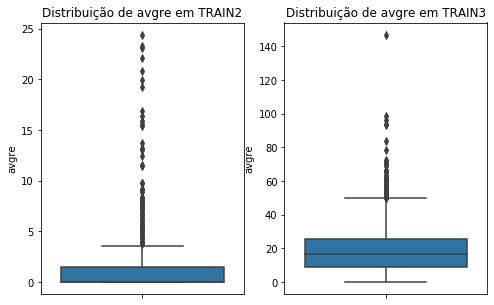

In [35]:
fig, axs = plt.subplots(ncols=2, figsize = (8,5))

ax0 = sns.boxplot(y="avgre", data=train2, ax = axs[0])
ax0.set_title("Distribuição de avgre em TRAIN2")
ax1 = sns.boxplot(y="avgre", data=train3, ax = axs[1])
ax1.set_title("Distribuição de avgre em TRAIN3")

In [36]:
## Usando apenas os homens com avgre < 10 em TRAIN2
train2_10 = train2.loc[train2['avgre'] <= 10]

x = train2_10[['train','re74','re75','educ','age','black','hisp']]
y = train2_10['re78']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     2.904
Date:                Thu, 18 Feb 2021   Prob (F-statistic):            0.00564
Time:                        16:07:00   Log-Likelihood:                -1393.0
No. Observations:                 427   AIC:                             2802.
Df Residuals:                     419   BIC:                             2834.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7369      2.446      0.710      0.4

In [37]:
## Usando apenas os homens com avgre < 10 em TRAIN3
train3_10 = train3.loc[train3['avgre'] <= 10]

x = train3_10[['train','re74','re75','educ','age','black','hisp']]
y = train3_10['re78']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.227
Method:                 Least Squares   F-statistic:                     33.11
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           2.89e-40
Time:                        16:07:00   Log-Likelihood:                -2668.6
No. Observations:                 765   AIC:                             5353.
Df Residuals:                     757   BIC:                             5390.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4480      2.141      1.610      0.1

In [38]:
## Vendo quantas pessoas com avgre < 10 participaram do treinamento
len(train3_10.loc[train3_10['train'] == 1])

179

In [39]:
## Selecioinando as amostras com homens desempregados em 1974 E 1975
train2_74_75 = train2.loc[(train2['unem74'] == 1) & (train2['unem75'] == 1)]
train3_74_75 = train3.loc[(train3['unem74'] == 1) & (train3['unem75'] == 1)]

In [40]:
#  Regressao simples de re78 sobre train em TRAIN2_74_75
x = train2_74_75[['train']]
y = train2_74_75['re78']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     7.144
Date:                Thu, 18 Feb 2021   Prob (F-statistic):            0.00797
Time:                        16:07:01   Log-Likelihood:                -879.83
No. Observations:                 280   AIC:                             1764.
Df Residuals:                     278   BIC:                             1771.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1124      0.430      9.563      0.0

In [41]:
#  Regressao simples de re78 sobre train em TRAIN3_74_75
x = train3_74_75[['train']]
y = train3_74_75['re78']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     18.52
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           2.36e-05
Time:                        16:07:01   Log-Likelihood:                -916.01
No. Observations:                 271   AIC:                             1836.
Df Residuals:                     269   BIC:                             1843.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1512      0.560      3.838      0.0

## Exercício C11

In [42]:
coletar_dados('MURDER')

MURDER.dta foi lido com sucesso!


,id,state,year,mrdrte,exec,unem,d90,d93,cmrdrte,cexec,cunem,cexec_1,cunem_1
0,1,AL,87,9.3,2,7.8,0,0,NaN,NaN,NaN,NaN,NaN
1,1,AL,90,11.6,5,6.8,1,0,2.3,3.0,-1.0,NaN,NaN
2,1,AL,93,11.6,2,7.5,0,1,0.0,-3.0,0.7,3.0,-1.0
3,2,AK,87,10.1,0,10.8,0,0,NaN,NaN,NaN,NaN,NaN
4,2,AK,90,7.5,0,6.9,1,0,-2.6,0.0,-3.9,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,50,WI,90,4.6,0,4.4,1,0,1.1,0.0,-1.7,NaN,NaN
149,50,WI,93,4.4,0,4.7,0,1,-0.2,0.0,0.3,0.0,-1.7
150,51,WY,87,2.0,0,8.6,0,0,NaN,NaN,NaN,NaN,NaN
151,51,WY,90,4.9,0,5.4,1,0,2.9,0.0,-3.2,NaN,NaN


In [43]:
## Pegando apenas os dados de 1993
df_93 = df.loc[df['year'] == 93]

# Fazendo a regressão
x =  df_93[['exec','unem']]
y = df_93['mrdrte']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                 mrdrte   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     3.126
Date:                Thu, 18 Feb 2021   Prob (F-statistic):             0.0529
Time:                        16:07:02   Log-Likelihood:                -189.70
No. Observations:                  51   AIC:                             385.4
Df Residuals:                      48   BIC:                             391.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.5686      6.315     -1.040      0.3

Text(0.5, 1.0, 'Distribuição do número de execuções entre 1990 e 1993')

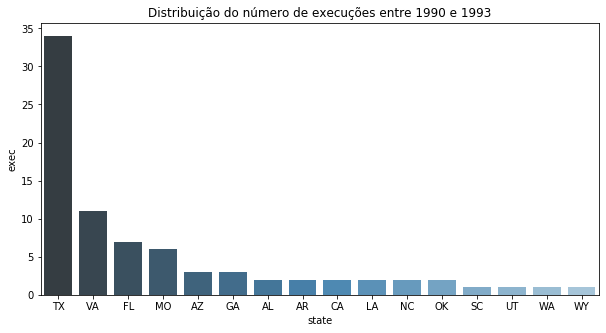

In [44]:
## Plotando a distribuicao do numero de execucoes
df_93_0 = df_93.loc[df_93['exec'] > 0]
df_93_0 = df_93_0.sort_values(['exec'], ascending=False).reset_index(drop=True)

fig, axs = plt.subplots(figsize = (10,5))

ax0 = sns.barplot(x="state",y="exec", data=df_93_0, palette="Blues_d")
ax0.set_title("Distribuição do número de execuções entre 1990 e 1993")

In [45]:
## Adicionando uma dummy para texas
df_93['tx'] = df_93['state'].apply(lambda i: 1 if i == 'TX' else 0)

## Fazendo a regressão
x =  df_93[['exec','unem','tx']]
y = df_93['mrdrte']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                 mrdrte   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     2.079
Date:                Thu, 18 Feb 2021   Prob (F-statistic):              0.116
Time:                        16:07:04   Log-Likelihood:                -189.65
No. Observations:                  51   AIC:                             387.3
Df Residuals:                      47   BIC:                             395.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.8265      6.426     -1.062      0.2

In [46]:
## Modificando o dataframe para conseguir a taxa de homicidios defasada
df_90_93 = df.loc[(df['year'] == 90) | (df['year'] == 93)]
df_90_93['mrdrte_90'] = df_90_93['mrdrte'].shift(1)
df_93 = df_90_93.loc[df_90_93['year'] == 93]

## Fazendo a regressão
x =  df_93[['exec','unem','mrdrte_90']]
y = df_93['mrdrte']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                 mrdrte   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1609.
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           2.34e-47
Time:                        16:07:04   Log-Likelihood:                -74.461
No. Observations:                  51   AIC:                             156.9
Df Residuals:                      47   BIC:                             164.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8826      0.676      1.306      0.1

In [47]:
## Adicionando uma dummy para texas
df_93['tx'] = df_93['state'].apply(lambda i: 1 if i == 'TX' else 0)

## Fazendo a regressão com a dummy de texas
x =  df_93[['exec','unem','mrdrte_90', 'tx']]
y = df_93['mrdrte']
Regressao_Multipla(x,y)

                            OLS Regression Results                            
Dep. Variable:                 mrdrte   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1185.
Date:                Thu, 18 Feb 2021   Prob (F-statistic):           9.55e-46
Time:                        16:07:05   Log-Likelihood:                -74.383
No. Observations:                  51   AIC:                             158.8
Df Residuals:                      46   BIC:                             168.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8491      0.688      1.234      0.2